import packages

In [9]:
# import sys, os
# from pathlib import Path
# sys.path.append(str(Path(os.getcwd()))+'/..')

import os
os.chdir('..')

from analysis.fidelity_prediction import FidelityModel
from baselines.fidelity_prediction.rb_prediction import RBModel
from simulator.gate_error_model import GateErrorModel

from analysis.vectorization import RandomwalkModel

from data_objects.random_circuit import random_circuits, random_circuit
from data_objects.backend import Backend, LinearBackend, GridBackend, FullyConnectedBackend

from simulator.noisy_simulator import NoisySimulator
import random

from tools.ray_func import map

model settings

In [10]:
n_qubits = 5
n_steps = 2
n_walks = 20
backend = LinearBackend(n_qubits, 1)


generate random circuit to train

In [11]:
circuits = random_circuits(backend, n_circuits=1000, n_gate_list=[30, 50, 100], two_qubit_prob_list=[.4], reverse=True)

train upstream model, turn a circuit to vectors using random walk

In [12]:
vec_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend)
gate_vecs_per_circuit = vec_model.train(circuits, multi_process=False, remove_redundancy = False)



start random walk for 1002 circuits


100%|██████████| 1002/1002 [00:13<00:00, 75.99it/s]


count path
device size after random walk = 9
0's path table size = 75
1's path table size = 150
2's path table size = 197
3's path table size = 150
4's path table size = 75
(0, 1)'s path table size = 95
(1, 2)'s path table size = 146
(2, 3)'s path table size = 146
(3, 4)'s path table size = 95


select interaction patterns randomly, simulate interaction between gates

In [13]:
all_paths = vec_model.all_paths()
high_error_paths = random.choices(all_paths, k = 20)

error_model = GateErrorModel.random_model(backend=backend, high_error_paths=high_error_paths)
error_model.vec_model = vec_model

simulator = NoisySimulator(backend=backend, gate_error_model = error_model)
ground_truth_fidelities = map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], circuits, show_progress=False, multi_process=True)

train fidelity prediction model

In [14]:
fidelity_model = FidelityModel(vec_model)
fidelity_model.train((circuits, ground_truth_fidelities))

len(train dataset) = 801, len(validation dataset) = 201


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


epoch: 0, 	 epoch loss = 3643.7880859375, 	 validation loss = 2.8403308391571045


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


epoch: 100, 	 epoch loss = 294.140380859375, 	 validation loss = 0.34145161509513855


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


epoch: 200, 	 epoch loss = 259.24749755859375, 	 validation loss = 0.30593249201774597


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


epoch: 300, 	 epoch loss = 240.35653686523438, 	 validation loss = 0.2865764796733856


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


epoch: 400, 	 epoch loss = 226.6422119140625, 	 validation loss = 0.2733851671218872


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


epoch: 500, 	 epoch loss = 215.159912109375, 	 validation loss = 0.2625362277030945


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


epoch: 600, 	 epoch loss = 205.74412536621094, 	 validation loss = 0.25464412569999695


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


epoch: 700, 	 epoch loss = 198.04273986816406, 	 validation loss = 0.24795739352703094


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


epoch: 800, 	 epoch loss = 191.90753173828125, 	 validation loss = 0.24267011880874634


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


epoch: 900, 	 epoch loss = 187.05735778808594, 	 validation loss = 0.23899640142917633
finish taining


prepare benchmark circuit

In [15]:
from data_objects.algorithms import get_algs
from optimizations.scheduling.scheduling_ct import Scheduler
from optimizations.mapping.mapping_ct import Mapper
scheduler = Scheduler(fidelity_model)
mapper = Mapper(fidelity_model)

algs = ['qft', 'hs', 'ising', 'qknn', 'qsvm', 'vqc', 'ghz', 'grover']
benchmarking_circuits = get_algs(n_qubits, backend, algs)

scheduling optimize and mapping optimize

In [16]:
no_opt, scheduling_opt, no_mapping, mapping_opt = [],[],[],[]
for circuit in benchmarking_circuits:
    opt_circuit = scheduler.run(circuit, timeout=30)
    
    before_opt_fidelity = simulator.obtain_circuit_fidelity(circuit)[0]
    after_opt_fidelity = simulator.obtain_circuit_fidelity(opt_circuit)[0]
    print('before scheduling: ', before_opt_fidelity, 'after scheduling: ', after_opt_fidelity)
    no_opt.append(before_opt_fidelity)
    scheduling_opt.append(after_opt_fidelity)

    mapping_backend = LinearBackend(n_qubits)
    
    opt_circuit, candicates = mapper.run(circuit, mapping_backend, return_candidates=True)
    
    before_opt_fidelity = [
        simulator.obtain_circuit_fidelity(circuit)[0]
        for circuit in candicates
    ]
    before_opt_fidelity = sum(before_opt_fidelity)/len(before_opt_fidelity)
    after_opt_fidelity = simulator.obtain_circuit_fidelity(opt_circuit)[0]
    no_mapping.append(before_opt_fidelity)
    mapping_opt.append(after_opt_fidelity)
    print('before mapping: ', before_opt_fidelity, 'after mapping: ', after_opt_fidelity)
    print('\n')
    
# print(no_opt.mean())
# print(scheduling_opt.mean())
# print(no_mapping.mean())
# print(mapping_opt.mean())

before scheduling:  0.7796157504008621 after scheduling:  0.7246540833456592
before selection: 0.37702417 after selection: 0.37702417
before mapping:  0.8171105895641915 after mapping:  0.8423593356909024


before scheduling:  0.5767192456023078 after scheduling:  0.5772416372380585
before selection: 0.7333364 after selection: 0.7333364
before mapping:  0.6311199106340426 after mapping:  0.7259243644359175


before scheduling:  0.6718115651314944 after scheduling:  0.8237990546728048
before selection: 0.64050984 after selection: 0.6405099
before mapping:  0.6818916852324699 after mapping:  0.5661681038839569


before scheduling:  0.5763657999604754 after scheduling:  0.6650683067573752
before selection: 0.51898104 after selection: 0.5189811
before mapping:  0.5961363606771461 after mapping:  0.6378208686813547


before scheduling:  0.5670383551766487 after scheduling:  0.6568080972280069
before selection: 0.6463035 after selection: 0.64630365
before mapping:  0.652150670825161 after ma

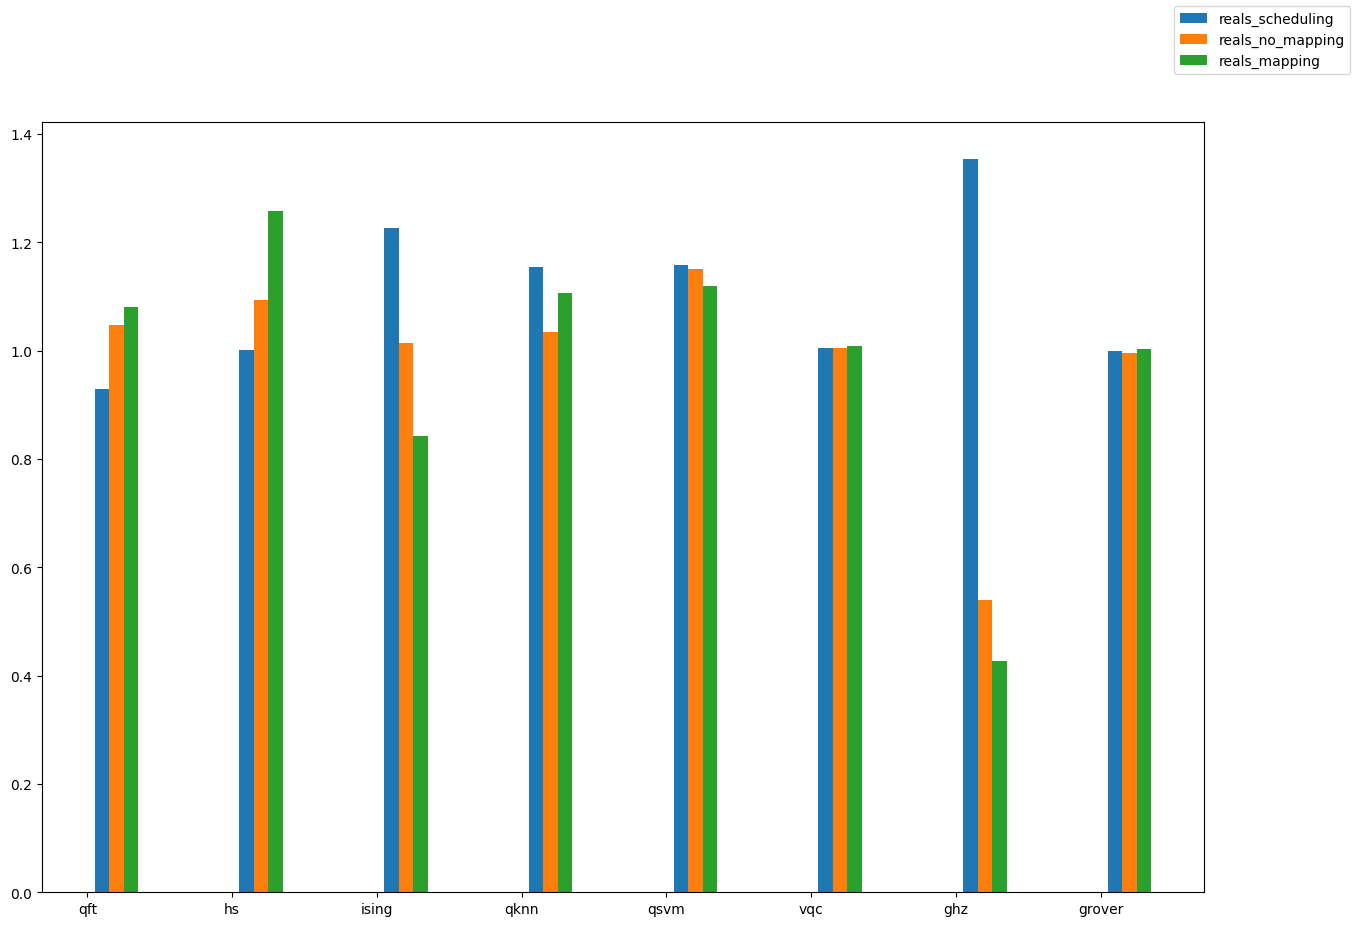

In [17]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(figsize=(15, 10))  
x = [i for i in range(len(benchmarking_circuits))]
x = np.array(x) * 20
# axes.bar(x,reals_baseline,width =2,label='reals_baseline')


no_opt = np.array(no_opt)
scheduling_opt = np.array(scheduling_opt)
no_mapping = np.array(no_mapping)
mapping_opt = np.array(mapping_opt)
axes.bar(x+2,scheduling_opt/no_opt,width =2,label='reals_scheduling')
axes.bar(x+4,no_mapping/no_opt,width =2,label='reals_no_mapping')
axes.bar(x+6,mapping_opt/no_opt,width =2,label='reals_mapping')

axes.set_xticks(x)
axes.set_xticklabels(algs)
fig.legend()
fig.savefig('improve.svg')

remove real world noise

In [18]:
all_path_errors = fidelity_model.get_all_path_errors()
top_k = len(all_path_errors) // 10
identified_path = set(path for path, error in all_path_errors[:top_k])

remain_path = set(high_error_paths) - identified_path



print(len(remain_path))
print(len(high_error_paths))


opt_error_model = GateErrorModel.random_model(backend=backend, high_error_paths=remain_path)
opt_error_model.vec_model = vec_model

opt_simulator = NoisySimulator(backend=backend, gate_error_model = error_model)
opt_ground_truth_fidelities = map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], circuits, show_progress=False, multi_process=True)

7
20


Through the fidelity model, we find the path that is most likely to generate noise. We can physically avoid such paths, thereby effectively improving fidelity.

In [19]:
print(np.array(ground_truth_fidelities).mean(), np.array(opt_ground_truth_fidelities).mean())

0.5832225548902196 0.5837449101796408
